### Libs import

In [1]:
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR
from scipy.signal import correlate
from statsmodels.graphics.tsaplots import plot_acf
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from nn_alpgotrading.data_processing import (
    load_data, 
    good_tickers_chooser, 
    DataResampler, 
    pct_calculator, 
    columns_renamer, 
    get_training_columns, 
    prepare_data, 
    generate_windows,
    prepare_train_data,
    prepare_test_data,
    handle_infs_and_nans,
    convert_to_tensor,
)

from nn_alpgotrading.training_process import TimeSeriesDataset, create_dataloader

# Устройство для работы с нейронными сетями
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### Dataloading & preprocessing

In [2]:
# Константы
PATH = 'data/binance/fut/hour'
RESAMPLE_INTERVAL = '4H'

# Шаг 1: Загрузка данных
close, open_, high, low, qvolume, bvolume, ntrades, takerbuybvolume, takerbuyqvolume = load_data(PATH)

# Шаг 2: Выбор тикеров с малым количеством пропусков
good_tickers = good_tickers_chooser(close)

# Шаг 3: Ресемплинг данных
close = DataResampler.resample_data(close, good_tickers, RESAMPLE_INTERVAL, 'last')
open_ = DataResampler.resample_data(open_, good_tickers, RESAMPLE_INTERVAL, 'first')
high = DataResampler.resample_data(high, good_tickers, RESAMPLE_INTERVAL, 'max')
low = DataResampler.resample_data(low, good_tickers, RESAMPLE_INTERVAL, 'min')
bvolume = DataResampler.resample_data(bvolume, good_tickers, RESAMPLE_INTERVAL, 'sum')
qvolume = DataResampler.resample_data(qvolume, good_tickers, RESAMPLE_INTERVAL, 'sum')
ntrades = DataResampler.resample_data(ntrades, good_tickers, RESAMPLE_INTERVAL, 'sum')
takerbuybvolume = DataResampler.resample_data(takerbuybvolume, good_tickers, RESAMPLE_INTERVAL, 'sum')
takerbuyqvolume = DataResampler.resample_data(takerbuyqvolume, good_tickers, RESAMPLE_INTERVAL, 'sum')

# Шаг 4: Подготовка колонок
returns = pct_calculator(close, is_returns=True)
returns = columns_renamer(returns, "ret")

close = columns_renamer(close, "close")
open_ = columns_renamer(open_, "open")
high = columns_renamer(high, "high")
low = columns_renamer(low, "low")
bvolume = columns_renamer(bvolume, "bvolume")
qvolume = columns_renamer(qvolume, "qvolume")
ntrades = columns_renamer(ntrades, "ntrades")
takerbuybvolume = columns_renamer(takerbuybvolume, "takerbuybvolume")
takerbuyqvolume = columns_renamer(takerbuyqvolume, "takerbuyqvolume")

# Шаг 5: Формирование полного DataFrame
full_data = prepare_data(
    close, open_, high, low, bvolume, qvolume, ntrades, takerbuybvolume, takerbuyqvolume, returns
)

# Шаг 6: Выбор колонок для обучения
close_col = close.columns.tolist()
open_col = open_.columns.tolist()
high_col = high.columns.tolist()
low_col = low.columns.tolist()
bvolume_col = bvolume.columns.tolist()
qvolume_col = qvolume.columns.tolist()
ntrades_col = ntrades.columns.tolist()
takerbuybvolume_col = takerbuybvolume.columns.tolist()
takerbuyqvolume_col = takerbuyqvolume.columns.tolist()

train_columns = get_training_columns(
    close_col, open_col, high_col, low_col, bvolume_col, qvolume_col, ntrades_col, takerbuybvolume_col, takerbuyqvolume_col
)

# Шаг 7: Подготовка данных для обучения
training_data = full_data[train_columns]

# Шаг 8: Генерация оконных выборок
window_size = 100
all_x, all_y = generate_windows(full_data, returns.columns.tolist(), window_size)

print(f"Размер данных X: {all_x.shape}")
print(f"Размер данных Y: {all_y.shape}")

Размер данных X: (7452, 100, 630)
Размер данных Y: (7452, 63)


In [3]:
# Формируем обучающую выборку
x_test = all_x[-850:].view()  # Все, кроме последних 1000
y_test = all_y[-850:].view()  # Все, кроме последних 1000

x = all_x[:-(850 + 120)].view()
y = all_y[:-(850 + 120)].view()

# Определяем длину валидационной выборки
val_len = 1000

# Определяем индексы для валидационной выборки
val_start = x.shape[0] // 2 - val_len // 2
val_end = val_start + val_len

# Формируем валидационную выборку
x_val = x[val_start:val_end]
y_val = y[val_start:val_end]

# Определяем отступы для тестовой выборки
offset = 110

# Индексы для тестовой выборки
test_start = max(0, val_start - offset)
test_end = min(x.shape[0], val_end + offset)

# Формируем тренировочную выборку
x_train = np.concatenate((x[:test_start], x[test_end:]), axis=0)
y_train = np.concatenate((y[:test_start], y[test_end:]), axis=0)

# Проверяем размеры выборок
print(f"train_x shape: {x_train.shape}")
print(f"train_y shape: {y_train.shape}")
print(f"val_x shape: {x_val.shape}")
print(f"val_y shape: {y_val.shape}")
print(f"test_x shape: {x_test.shape}")
print(f"test_y shape: {y_test.shape}")

train_x shape: (5262, 100, 630)
train_y shape: (5262, 63)
val_x shape: (1000, 100, 630)
val_y shape: (1000, 63)
test_x shape: (850, 100, 630)
test_y shape: (850, 63)


In [4]:
# Обработка NaN и бесконечностей для всех выборок
x_train = handle_infs_and_nans(x_train)
y_train = handle_infs_and_nans(y_train)
x_val = handle_infs_and_nans(x_val)
y_val = handle_infs_and_nans(y_val)
x_test = handle_infs_and_nans(x_test)
y_test = handle_infs_and_nans(y_test)

# Конвертация в тензоры
x_train, y_train = convert_to_tensor(x_train, y_train)
x_val, y_val = convert_to_tensor(x_val, y_val)
x_test, y_test = convert_to_tensor(x_test, y_test)

In [5]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

torch.Size([5262, 100, 630]) torch.Size([5262, 63])
torch.Size([1000, 100, 630]) torch.Size([1000, 63])
torch.Size([850, 100, 630]) torch.Size([850, 63])


Dimensional control

In [6]:
# Вывод размеров выборок
print("Shape of x_train:", x_train.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_train.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_val:", x_val.shape)  # Ожидаемая форма: (1000, 50, 465)
print("Shape of y_val:", y_val.shape)  # Ожидаемая форма: (1000,)

print("Shape of x_test:", x_test.shape)  # Ожидаемая форма: (850, 50, 465)
print("Shape of y_test:", y_test.shape)  # Ожидаемая форма: (850,)

Shape of x_train: torch.Size([5262, 100, 630])
Shape of y_train: torch.Size([5262, 63])
Shape of x_val: torch.Size([1000, 100, 630])
Shape of y_val: torch.Size([1000, 63])
Shape of x_test: torch.Size([850, 100, 630])
Shape of y_test: torch.Size([850, 63])


### Learning

In [33]:
share_values = []
weights_penalties = []
turnover_penalties = []

# Создаем dataset и dataloader
train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)
test_dataset = TimeSeriesDataset(x_test, y_test)

batch_size = 150  # Выбираем подходящий размер батча

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
x_train.shape

torch.Size([5262, 100, 630])

In [35]:
from nn_alpgotrading.networks import AttentionMLP, ConvLSTMWithAttention
from nn_alpgotrading.loss_functions import SharpeLoss, DynamicPortfolioLoss

In [36]:
sharpe_loss = SharpeLoss(turnover_penalty_weight=10)
returns_loss = DynamicPortfolioLoss(turnover_weight=1.5, min_turnover=0)

  0%|          | 0/100 [00:00<?, ?it/s]

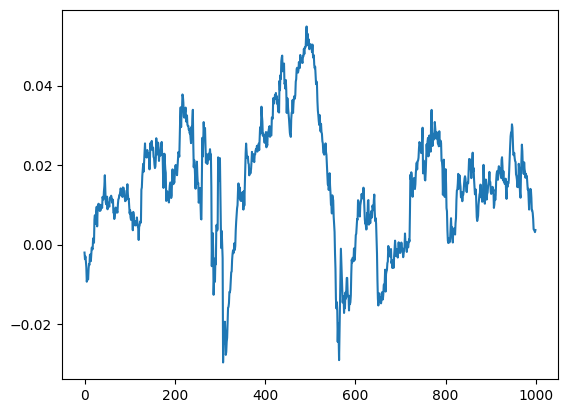

Epoch [0/100], Loss: -0.0042546830, Validation Loss: 0.0006959764
Train Margin returns: 0.0001777875, Val Margin returns: -0.0002053827
Train Turnover Penalty: 0.0021641546, Val Turnover Penalty: 0.2743058354



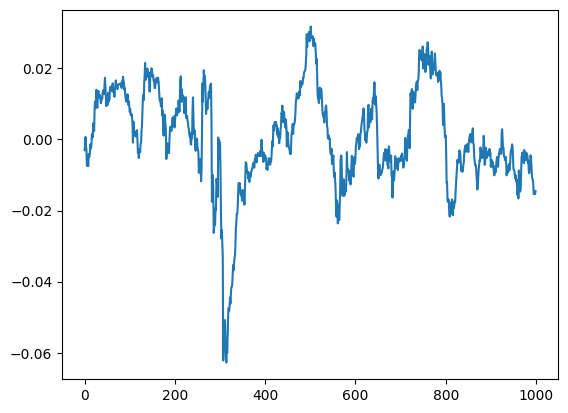

Epoch [1/100], Loss: -0.0093732866, Validation Loss: 0.0010487082
Train Margin returns: 0.0004253805, Val Margin returns: -0.0003261575
Train Turnover Penalty: 0.0021396764, Val Turnover Penalty: 0.3032675045



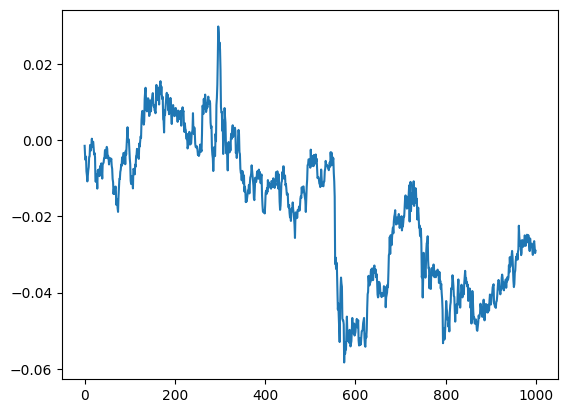

Epoch [2/100], Loss: -0.0156057610, Validation Loss: -0.0073316803
Train Margin returns: 0.0006350222, Val Margin returns: 0.0008234171
Train Turnover Penalty: 0.0018545245, Val Turnover Penalty: 0.0154294930



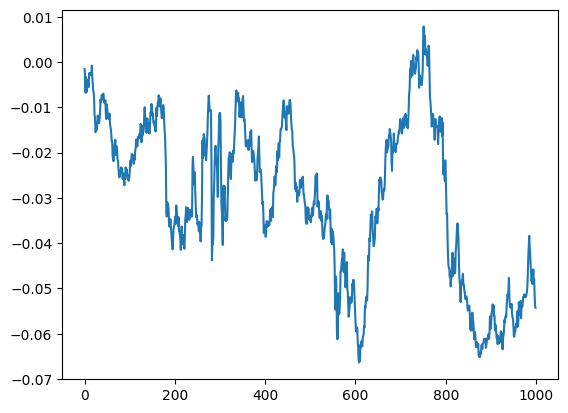

Epoch [3/100], Loss: -0.1596423159, Validation Loss: -0.2976031027
Train Margin returns: 0.0034528440, Val Margin returns: 0.0060866547
Train Turnover Penalty: 0.0004957714, Val Turnover Penalty: 0.0004203926



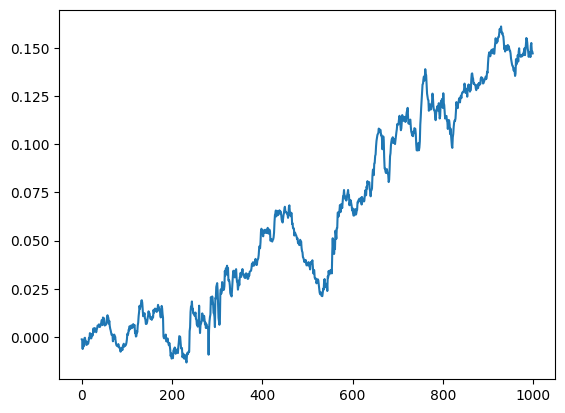

Epoch [4/100], Loss: -0.4860661762, Validation Loss: -0.7140330843
Train Margin returns: 0.0065405906, Val Margin returns: 0.0076064784
Train Turnover Penalty: 0.0001715310, Val Turnover Penalty: 0.0001167748



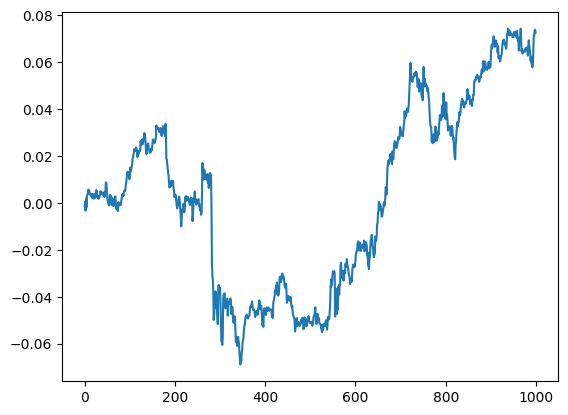

Epoch [5/100], Loss: -0.8085610349, Validation Loss: -1.0937498169
Train Margin returns: 0.0073551123, Val Margin returns: 0.0095342704
Train Turnover Penalty: 0.0000834428, Val Turnover Penalty: 0.0000757772



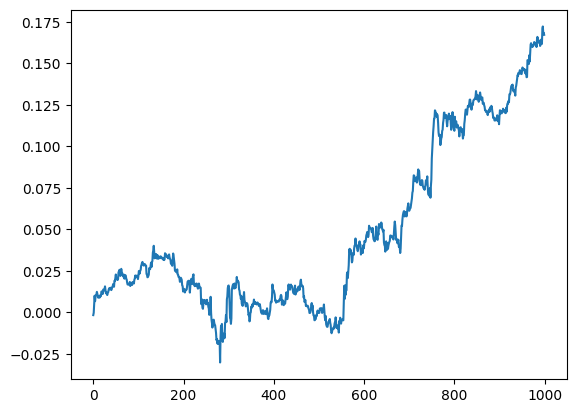

Epoch [6/100], Loss: -1.2175277927, Validation Loss: -1.2506339805
Train Margin returns: 0.0082579208, Val Margin returns: 0.0074496925
Train Turnover Penalty: 0.0000436357, Val Turnover Penalty: 0.0000366694



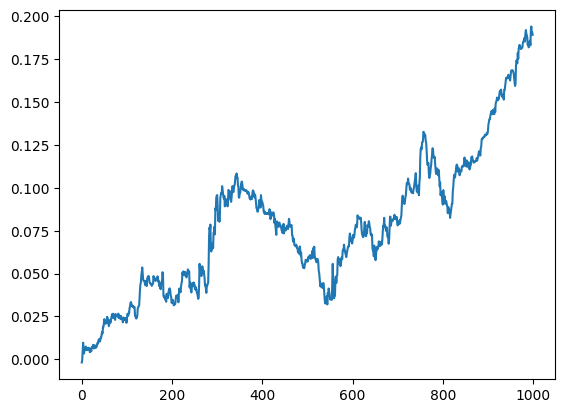

Epoch [7/100], Loss: -1.3649309820, Validation Loss: -1.3871661425
Train Margin returns: 0.0075141579, Val Margin returns: 0.0073292721
Train Turnover Penalty: 0.0000317502, Val Turnover Penalty: 0.0000289757



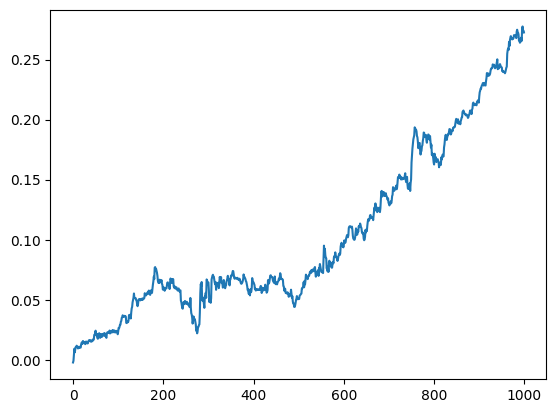

Epoch [8/100], Loss: -1.5941618789, Validation Loss: -1.9424246720
Train Margin returns: 0.0072299163, Val Margin returns: 0.0078579367
Train Turnover Penalty: 0.0000198951, Val Turnover Penalty: 0.0000169431



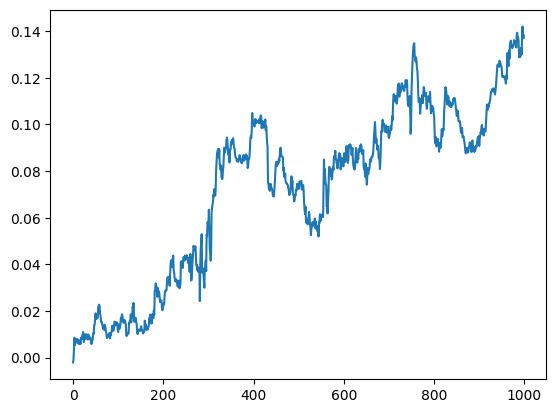

Epoch [9/100], Loss: -1.7142427936, Validation Loss: -1.8283749904
Train Margin returns: 0.0068362841, Val Margin returns: 0.0066733082
Train Turnover Penalty: 0.0000156126, Val Turnover Penalty: 0.0000130624



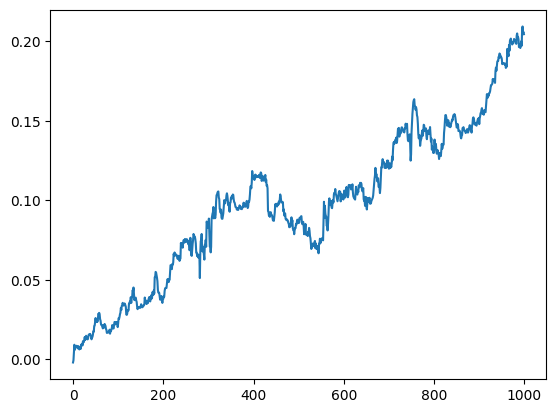

Epoch [10/100], Loss: -1.9645444291, Validation Loss: -1.9828343306
Train Margin returns: 0.0065952991, Val Margin returns: 0.0073415131
Train Turnover Penalty: 0.0000123225, Val Turnover Penalty: 0.0000134589



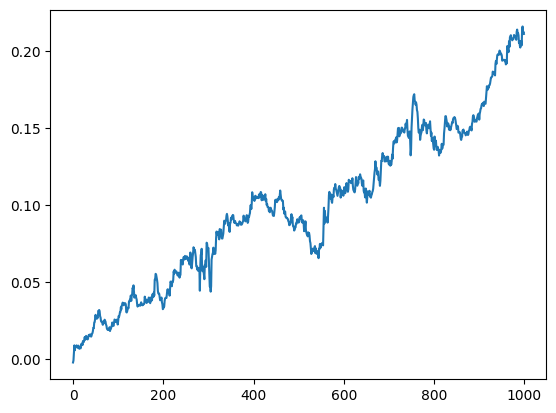

Epoch [11/100], Loss: -1.9974604266, Validation Loss: -2.1867065855
Train Margin returns: 0.0068837416, Val Margin returns: 0.0078960422
Train Turnover Penalty: 0.0000127029, Val Turnover Penalty: 0.0000130399



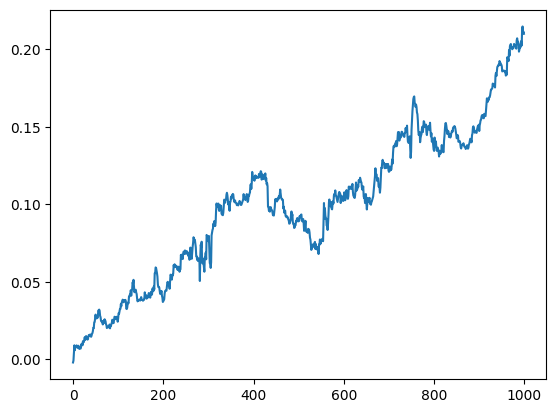

Epoch [12/100], Loss: -2.2142712979, Validation Loss: -2.2352818336
Train Margin returns: 0.0074257611, Val Margin returns: 0.0080179916
Train Turnover Penalty: 0.0000119087, Val Turnover Penalty: 0.0000128657



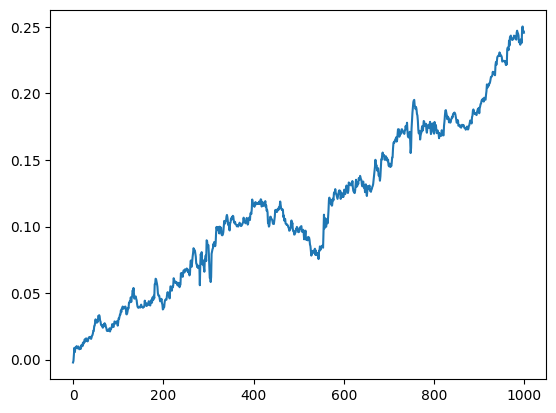

Epoch [13/100], Loss: -2.1153631831, Validation Loss: -2.3921774966
Train Margin returns: 0.0071148143, Val Margin returns: 0.0084252961
Train Turnover Penalty: 0.0000145595, Val Turnover Penalty: 0.0000124873



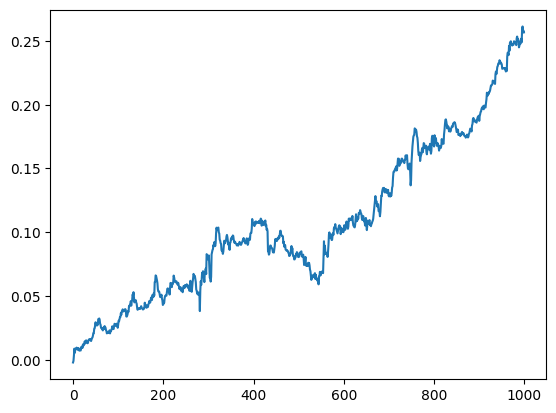

Epoch [14/100], Loss: -2.3505079423, Validation Loss: -2.4131807600
Train Margin returns: 0.0075964246, Val Margin returns: 0.0084047037
Train Turnover Penalty: 0.0000109783, Val Turnover Penalty: 0.0000122293



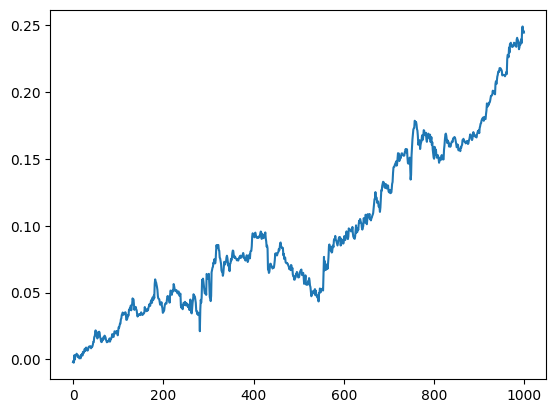

Epoch [15/100], Loss: -2.3659886635, Validation Loss: -2.4544848800
Train Margin returns: 0.0074867113, Val Margin returns: 0.0085040876
Train Turnover Penalty: 0.0000105599, Val Turnover Penalty: 0.0000124894



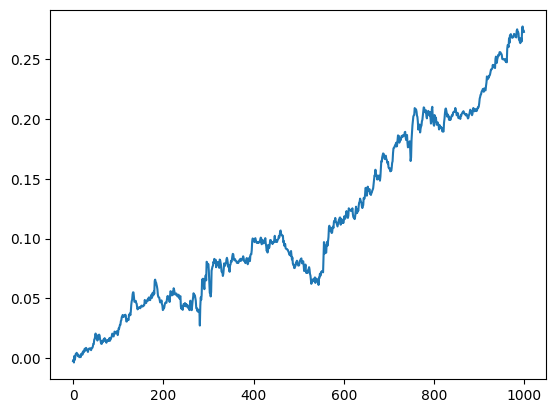

Epoch [16/100], Loss: -2.4296885125, Validation Loss: -2.7582066400
Train Margin returns: 0.0076555522, Val Margin returns: 0.0092451162
Train Turnover Penalty: 0.0000104357, Val Turnover Penalty: 0.0000116741



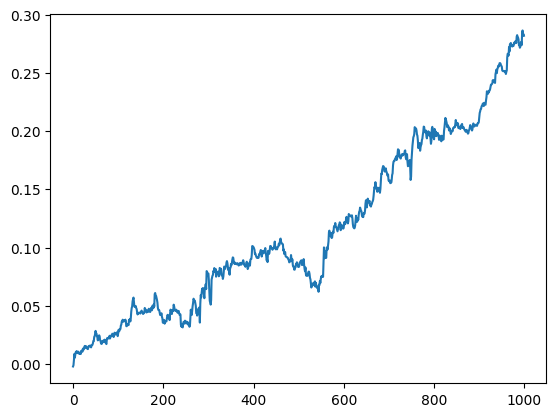

Epoch [17/100], Loss: -2.5113725348, Validation Loss: -2.9394061225
Train Margin returns: 0.0078112912, Val Margin returns: 0.0097117649
Train Turnover Penalty: 0.0000101809, Val Turnover Penalty: 0.0000114802



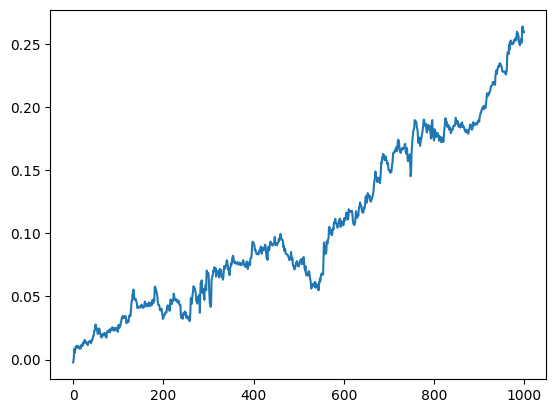

Epoch [18/100], Loss: -2.5036973870, Validation Loss: -2.9145123959
Train Margin returns: 0.0077693144, Val Margin returns: 0.0096275611
Train Turnover Penalty: 0.0000103023, Val Turnover Penalty: 0.0000114939



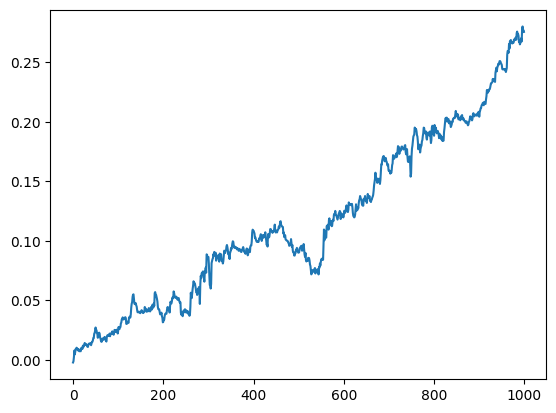

Epoch [19/100], Loss: -2.6386207251, Validation Loss: -3.0033851181
Train Margin returns: 0.0079946926, Val Margin returns: 0.0098203873
Train Turnover Penalty: 0.0000097388, Val Turnover Penalty: 0.0000111599



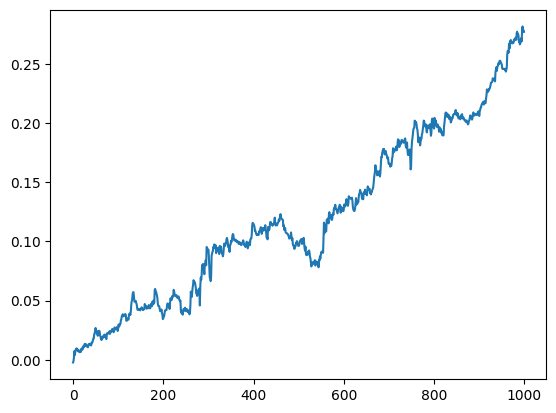

Epoch [20/100], Loss: -2.6545057702, Validation Loss: -3.0048763752
Train Margin returns: 0.0079571781, Val Margin returns: 0.0097862090
Train Turnover Penalty: 0.0000097310, Val Turnover Penalty: 0.0000110665



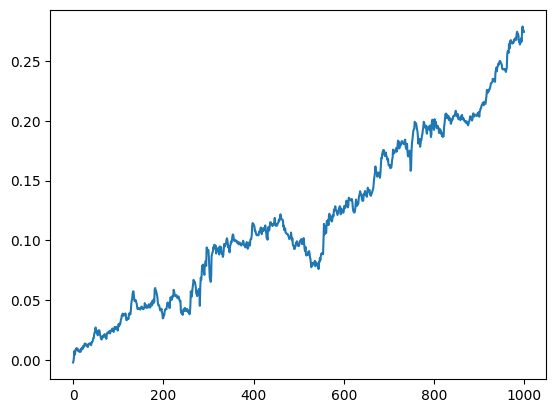

Epoch [21/100], Loss: -2.7185668407, Validation Loss: -3.0082279955
Train Margin returns: 0.0082310225, Val Margin returns: 0.0097786415
Train Turnover Penalty: 0.0000097789, Val Turnover Penalty: 0.0000110146



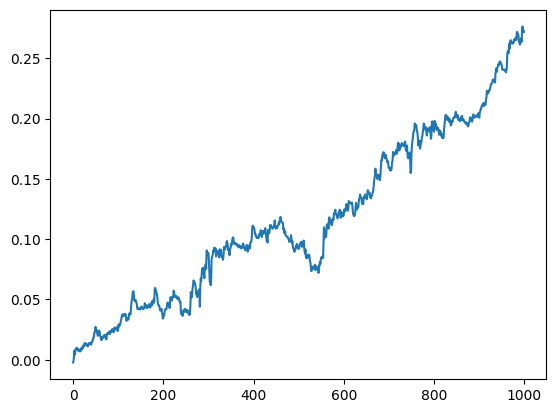

Epoch [22/100], Loss: -2.7378187958, Validation Loss: -3.0129428080
Train Margin returns: 0.0081484111, Val Margin returns: 0.0097808877
Train Turnover Penalty: 0.0000096544, Val Turnover Penalty: 0.0000109758



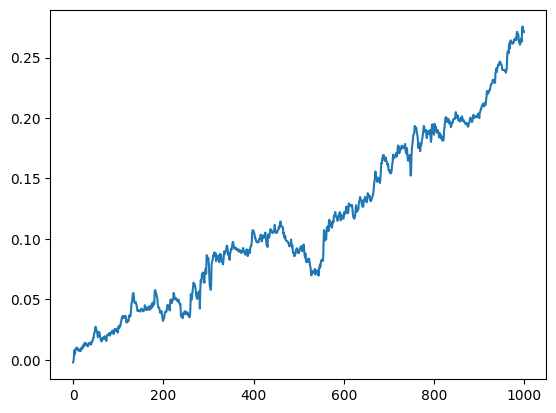

Epoch [23/100], Loss: -2.7040716401, Validation Loss: -3.0092199871
Train Margin returns: 0.0081491922, Val Margin returns: 0.0097676786
Train Turnover Penalty: 0.0000097073, Val Turnover Penalty: 0.0000109752



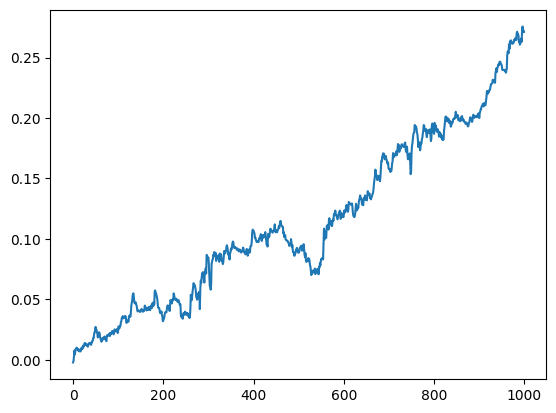

Epoch [24/100], Loss: -2.6900537593, Validation Loss: -3.0096687419
Train Margin returns: 0.0080654359, Val Margin returns: 0.0097632107
Train Turnover Penalty: 0.0000097686, Val Turnover Penalty: 0.0000109618



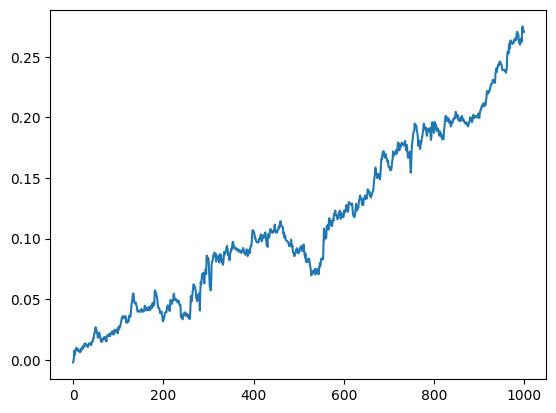

Epoch [25/100], Loss: -2.7013793762, Validation Loss: -3.0099058322
Train Margin returns: 0.0081237667, Val Margin returns: 0.0097489943
Train Turnover Penalty: 0.0000095629, Val Turnover Penalty: 0.0000109305



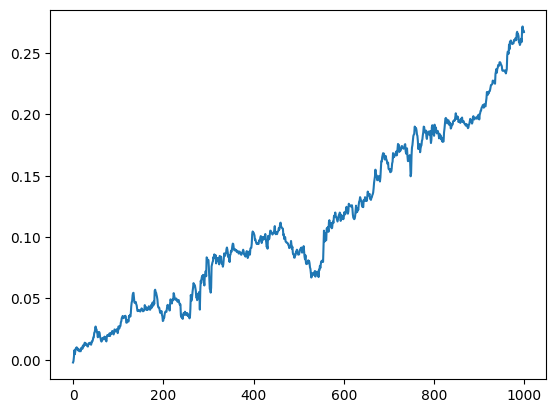

Epoch [26/100], Loss: -2.7366317477, Validation Loss: -3.0222505501
Train Margin returns: 0.0082085646, Val Margin returns: 0.0097811406
Train Turnover Penalty: 0.0000097377, Val Turnover Penalty: 0.0000109113



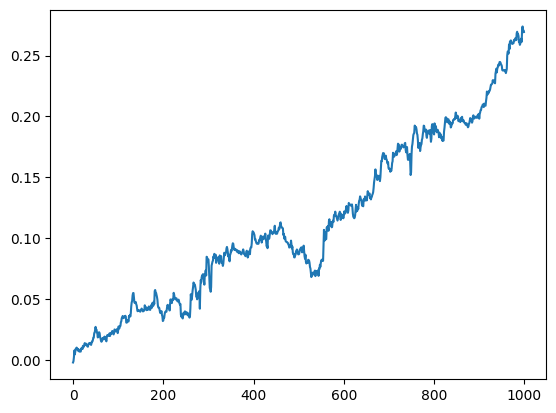

Epoch [27/100], Loss: -2.6588628180, Validation Loss: -3.0215133088
Train Margin returns: 0.0079574331, Val Margin returns: 0.0097721214
Train Turnover Penalty: 0.0000096687, Val Turnover Penalty: 0.0000108923



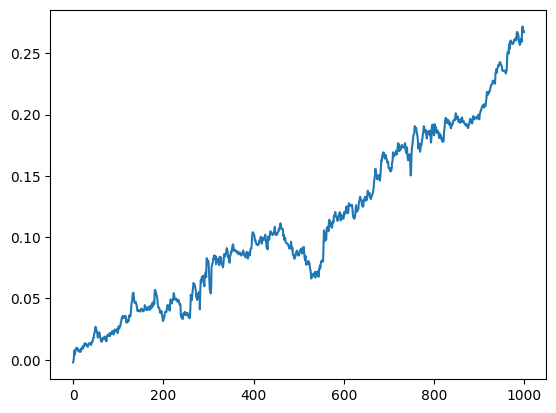

Epoch [28/100], Loss: -2.6945479446, Validation Loss: -3.0244800193
Train Margin returns: 0.0080217311, Val Margin returns: 0.0097727547
Train Turnover Penalty: 0.0000095222, Val Turnover Penalty: 0.0000108734



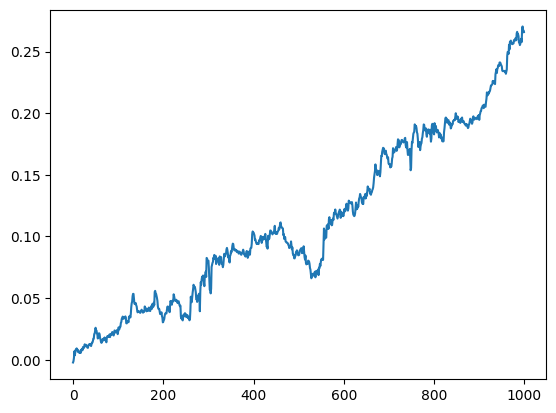

Epoch [29/100], Loss: -2.6899976763, Validation Loss: -3.0315684421
Train Margin returns: 0.0080803515, Val Margin returns: 0.0097965378
Train Turnover Penalty: 0.0000096422, Val Turnover Penalty: 0.0000108760



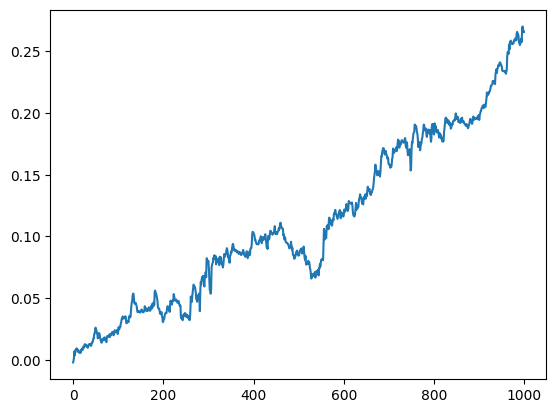

Epoch [30/100], Loss: -2.7163959088, Validation Loss: -3.0301529510
Train Margin returns: 0.0081358006, Val Margin returns: 0.0097905531
Train Turnover Penalty: 0.0000096722, Val Turnover Penalty: 0.0000108721



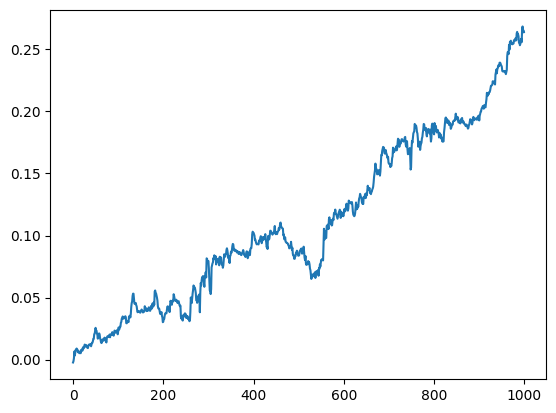

Epoch [31/100], Loss: -2.7082537926, Validation Loss: -3.0327671426
Train Margin returns: 0.0080497846, Val Margin returns: 0.0097960306
Train Turnover Penalty: 0.0000095523, Val Turnover Penalty: 0.0000108680



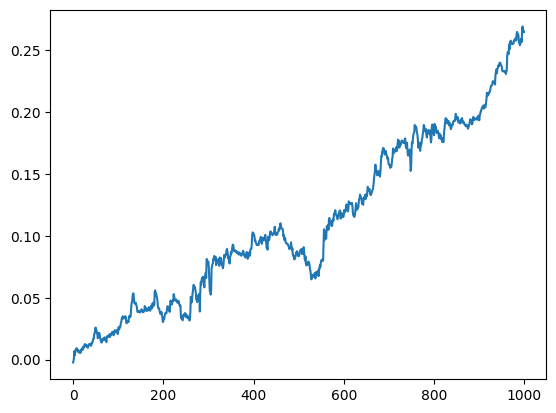

Epoch [32/100], Loss: -2.7416905488, Validation Loss: -3.0343881164
Train Margin returns: 0.0080684367, Val Margin returns: 0.0098041269
Train Turnover Penalty: 0.0000092867, Val Turnover Penalty: 0.0000108730



KeyboardInterrupt: 

In [37]:
PRINT_PARAM = 1
num_epochs = 100

pred_dict = {}
pred_dict['train'] = []
pred_dict['val'] = []
pred_dict['test'] = []

model = ConvLSTMWithAttention(
    input_size=x_train.shape[2], hidden_size=21, hidden_size2=21,
    output_size=y_train.shape[1], dropout=0.2, dropout2=0.2,
    num_heads=3, conv_out_channels=64).to(device)

criterion = returns_loss.to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

train_losses = []
val_losses = []
train_sharpe_ratios = []
train_volatility_values = []

val_sharpe_ratios = []
train_turnovers = []
val_turnovers = []
val_volatility_values = []

# Early stopping threshold для Val Margin returns
early_stopping_threshold = 0.01
best_val_sharpe = float('-inf')  # Инициализируем худшим возможным значением

# Параметры EMA
ema_alpha = 0.1  # Коэффициент сглаживания для EMA
ema_val_sharpe = 0
ema_val_turnover = 0


for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    epoch_sharpe = 0
    epoch_turnover = 0
    epoch_volatility = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход (forward pass)
        outputs = model(batch_x)

        # Вычисление потерь
        loss, sharpe_ratio, turnover = criterion(outputs.squeeze(), batch_y.float())

        # Обратный проход (backward pass) для вычисления градиентов
        loss.backward()

        # Обновление весов
        optimizer.step()

        # Агрегация потерь за эпоху
        epoch_loss += loss.item()
        epoch_sharpe += sharpe_ratio
        epoch_turnover += turnover
        # epoch_volatility += tvolatility

    epoch_loss /= len(train_loader)
    epoch_sharpe /= len(train_loader)
    epoch_turnover /= len(train_loader)
    epoch_volatility /= len(train_loader)

    train_losses.append(epoch_loss)
    train_sharpe_ratios.append(epoch_sharpe)
    train_turnovers.append(epoch_turnover)
    train_volatility_values.append(epoch_volatility)

    # Валидация модели
    model.eval()
    val_loss = 0
    val_sharpe = 0
    val_turnover = 0
    val_volatility = 0
    
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_outputs = model(val_x)
            loss, sharpe_ratio, turnover = criterion(val_outputs.squeeze(), val_y.float())

            val_loss += loss.item()
            val_sharpe += sharpe_ratio
            val_turnover += turnover
            # val_volatility += vvolatility

    with torch.no_grad():
        x_val = x_val.to(device)
        full_val_outputs = model(x_val)

    res = pd.DataFrame(full_val_outputs.cpu().numpy())
    res = res.sub(res.mean(axis=1), axis=0)
    res = res.div(res.abs().sum(axis=1), axis=0)
    (res * pd.DataFrame(y_val)).sum(axis=1).cumsum().plot()
    plt.show()

    val_loss /= len(val_loader)
    val_sharpe /= len(val_loader)
    val_turnover /= len(val_loader)
    val_volatility /= len(val_loader)

    val_losses.append(val_loss)
    val_sharpe_ratios.append(val_sharpe)
    val_turnovers.append(val_turnover)
    val_volatility_values.append(val_volatility)

    # # Экспоненциальное сглаживание для метрик
    # ema_val_sharpe = ema_alpha * val_sharpe + (1 - ema_alpha) * ema_val_sharpe
    # ema_val_turnover = ema_alpha * val_turnover + (1 - ema_alpha) * ema_val_turnover

    # Обновление learning rate через scheduler
    scheduler.step()

    # Адаптивное снижение weight decay на поздних эпохах
    if epoch == 50:
        for param_group in optimizer.param_groups:
            param_group['weight_decay'] *= 0.5

    # Печать результатов
    if epoch % PRINT_PARAM == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.10f}, Validation Loss: {val_loss:.10f}')
        print(f'Train Margin returns: {epoch_sharpe:.10f}, Val Margin returns: {val_sharpe:.10f}')
        print(f'Train Turnover Penalty: {epoch_turnover:.10f}, Val Turnover Penalty: {val_turnover:.10f}')
        # print(f"EMA Val Sharpe: {ema_val_sharpe:.10f}, EMA Val Turnover: {ema_val_turnover:.10f}")
        # print('train_volatility:', tvolatility, 'val_volatility:', vvolatility)
        print()

    # Early stopping на основе двух метрик (val_sharpe и val_turnover)
    # if val_sharpe > best_val_sharpe and val_turnover < early_stopping_threshold:
    #     best_val_sharpe = val_sharpe  # Обновляем лучшее значение
    #     print(f"Early stopping at epoch {epoch} based on Sharpe Ratio and turnover threshold.")
    #     break

# Визуализация потерь и компонентов функции потерь
plt.figure(figsize=(10, 5))
plt.plot(range(PRINT_PARAM, len(train_losses) + 1, PRINT_PARAM), train_losses, label='Train Loss')
plt.scatter(range(PRINT_PARAM, len(val_losses) + 1, PRINT_PARAM), val_losses, label='Validation Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(PRINT_PARAM, len(train_sharpe_ratios) + 1, PRINT_PARAM), train_sharpe_ratios, label='Train Margin returns')
plt.scatter(range(PRINT_PARAM, len(val_sharpe_ratios) + 1, PRINT_PARAM), val_sharpe_ratios, label='Validation Margin returns', color='r')
plt.xlabel('Epoch')
plt.ylabel('Margin returns')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(PRINT_PARAM, len(train_turnovers) + 1, PRINT_PARAM), train_turnovers, label='Train Turnover')
plt.scatter(range(PRINT_PARAM, len(val_turnovers) + 1, PRINT_PARAM), val_turnovers, label='Validation Turnover', color='r')
plt.xlabel('Epoch')
plt.ylabel('Turnover')
plt.legend()
plt.show()

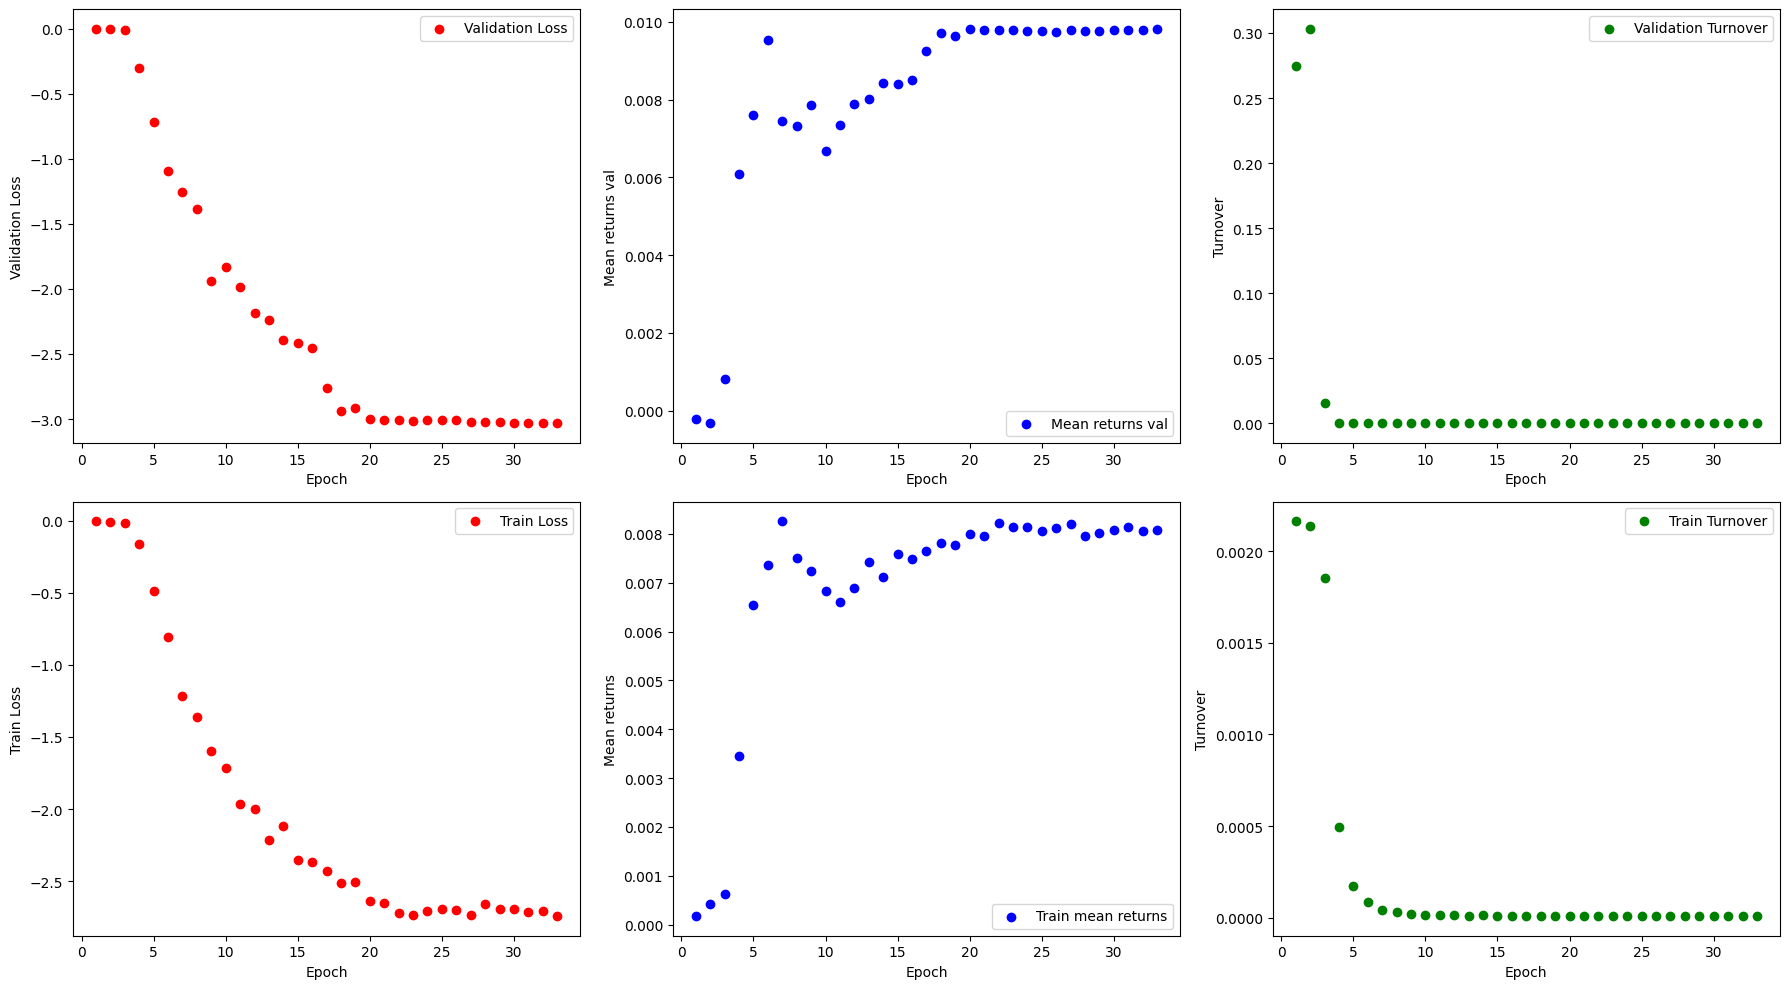

In [38]:
# Создаем 2 строки по 3 графика в каждой (валидация и тренировка)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 строки и 3 колонки

# Первая строка - Validation
# Первый график: Validation Loss
axes[0, 0].scatter(range(PRINT_PARAM, len(val_losses) + 1, PRINT_PARAM), val_losses, label='Validation Loss', color='r')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Validation Loss')
axes[0, 0].legend()

# Второй график: Validation Sharpe Ratio
axes[0, 1].scatter(range(PRINT_PARAM, len(val_sharpe_ratios) + 1, PRINT_PARAM), val_sharpe_ratios, label='Mean returns val', color='b')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Mean returns val')
axes[0, 1].legend()

# Третий график: Validation Turnover
axes[0, 2].scatter(range(PRINT_PARAM, len(val_turnovers) + 1, PRINT_PARAM), val_turnovers, label='Validation Turnover', color='g')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Turnover')
axes[0, 2].legend()

# Вторая строка - Train
# Первый график: Train Loss
axes[1, 0].scatter(range(PRINT_PARAM, len(train_losses) + 1, PRINT_PARAM), train_losses, label='Train Loss', color='r')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Train Loss')
axes[1, 0].legend()

# Второй график: Train Sharpe Ratio
axes[1, 1].scatter(range(PRINT_PARAM, len(train_sharpe_ratios) + 1, PRINT_PARAM), train_sharpe_ratios, label='Train mean returns', color='b')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Mean returns')
axes[1, 1].legend()

# Третий график: Train Turnover
axes[1, 2].scatter(range(PRINT_PARAM, len(train_turnovers) + 1, PRINT_PARAM), train_turnovers, label='Train Turnover', color='g')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Turnover')
axes[1, 2].legend()

# Отображаем все графики
plt.tight_layout()  # Для корректного отображения всех графиков без наложения

plt.show()

-0.008503369688987732 0.2728904128074646


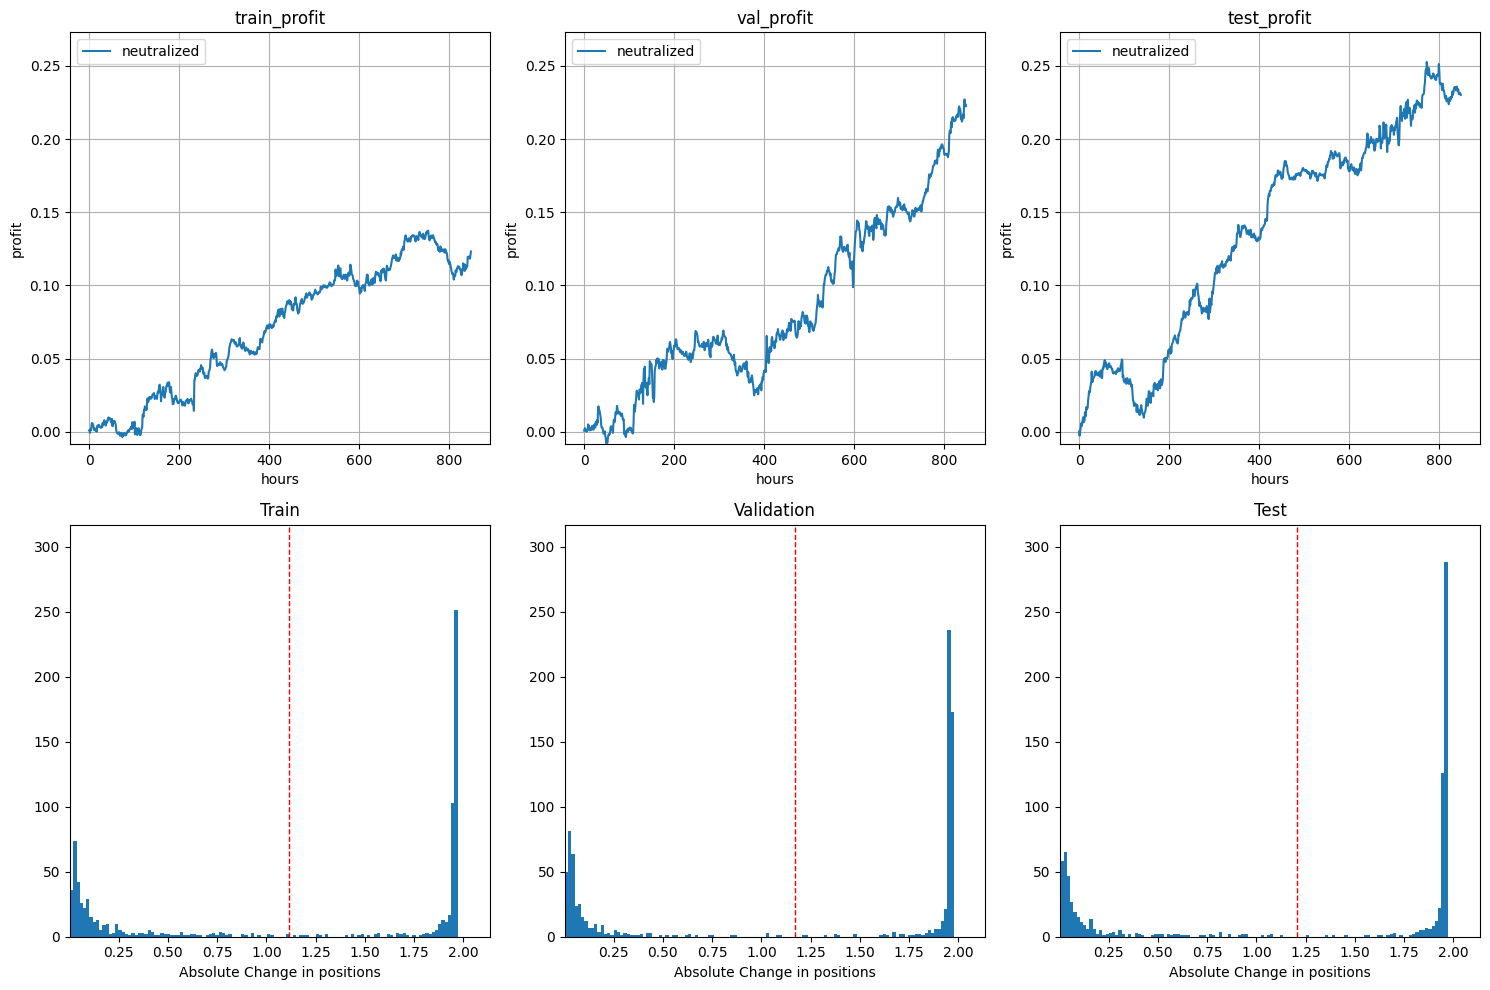

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

model.eval()
with torch.no_grad():
    train_predictions = model(x_train[-850:].to(device)).detach().cpu().numpy()

pred_dict['train'].append(train_predictions)

pred_df = pd.DataFrame(train_predictions, columns=close.columns)
alpha1 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
alpha1 = alpha1.div(alpha1.abs().sum(axis=1), axis=0)
axes[0, 0].plot(
    (alpha1.iloc[-850:] * pd.DataFrame(y_train[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum(),
    label='neutralized'
)
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_title('train_profit')
axes[0, 0].set_xlabel('hours')
axes[0, 0].set_ylabel('profit')
axes[0, 0].grid(True)  # Добавление сетки

with torch.no_grad():
    val_predictions = model(x_val[-850:].to(device)).detach().cpu().numpy()

pred_dict['val'].append(val_predictions)

pred_df = pd.DataFrame(val_predictions, columns=close.columns)
alpha2 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
alpha2 = alpha2.div(alpha2.abs().sum(axis=1), axis=0)
axes[0, 1].plot(
    (alpha2.iloc[-850:] * pd.DataFrame(y_val[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum(),
    label='neutralized'
)
axes[0, 1].legend(loc='upper left')
axes[0, 1].set_title('val_profit')
axes[0, 1].set_xlabel('hours')
axes[0, 1].set_ylabel('profit')
axes[0, 1].grid(True)  # Добавление сетки

with torch.no_grad():
    test_predictions = model(x_test.to(device)).detach().cpu().numpy()

pred_dict['test'].append(test_predictions)

pred_df = pd.DataFrame(test_predictions, columns=close.columns)
alpha3 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
alpha3 = alpha3.div(alpha3.abs().sum(axis=1), axis=0)
axes[0, 2].plot(
    (alpha3.iloc[-len(x_test):] * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).sum(axis=1).cumsum(),
    label='neutralized'
)
axes[0, 2].legend(loc='upper left')
axes[0, 2].set_title('test_profit')
axes[0, 2].set_xlabel('hours')
axes[0, 2].set_ylabel('profit')
axes[0, 2].grid(True)  # Добавление сетки

# Установим одинаковые пределы по оси y для всех графиков
min_value = min(
    (alpha1.iloc[-850:] * pd.DataFrame(y_train[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().min(),
    (alpha2.iloc[-850:] * pd.DataFrame(y_val[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().min(),
    (alpha3.iloc[-850:] * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().min(),
)
max_value = max(
    (alpha1.iloc[-850:] * pd.DataFrame(y_train[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().max(),
    (alpha2.iloc[-850:] * pd.DataFrame(y_val[-850:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().max(),
    (alpha3.iloc[-850:] * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().max()
)

min_value = min_value * 1.08 if min_value <= 0 else min_value - 0.03 * abs(max_value)
max_value = max_value * 1.08 if max_value >= 0 else max_value + 0.03 * abs(max_value)

print(min_value, max_value)

for i in range(3):
    axes[0, i].set_ylim(min_value, max_value)  # Одинаковые пределы по оси y для верхних графиков

# Рассчитаем минимальные и максимальные значения для оси x
x_min = min(alpha1.diff().abs().dropna().sum(axis=1).min(),
            alpha2.diff().abs().dropna().sum(axis=1).min(),
            alpha3.diff().abs().dropna().sum(axis=1).min())

x_max = max(alpha1.diff().abs().dropna().sum(axis=1).max(),
            alpha2.diff().abs().dropna().sum(axis=1).max(),
            alpha3.diff().abs().dropna().sum(axis=1).max())

x_min = x_min * 1.08
x_max = x_max * 1.08

# Построение гистограмм
hist_values1, bin_edges1 = np.histogram(alpha1.diff().abs().dropna().sum(axis=1), bins=120)
hist_values2, bin_edges2 = np.histogram(alpha2.diff().abs().dropna().sum(axis=1), bins=120)
hist_values3, bin_edges3 = np.histogram(alpha3.diff().abs().dropna().sum(axis=1), bins=120)

# Максимальное значение гистограммы
max_value = max([np.max(hist_values1), np.max(hist_values2), np.max(hist_values3)])

axes[1, 0].hist(alpha1.diff().abs().dropna().sum(axis=1), bins=120)
axes[1, 1].hist(alpha2.diff().abs().dropna().sum(axis=1), bins=120)
axes[1, 2].hist(alpha3.diff().abs().dropna().sum(axis=1), bins=120)

# Одинаковые пределы для оси y на гистограммах
for i in range(3):
    axes[1, i].set_ylim(0, max_value * 1.1)

# Установим одинаковые пределы по оси x для всех гистограмм
for ax in axes[1, :]:
    ax.set_xlim([x_min, x_max])

# Добавление вертикальных линий среднего
mean_alpha1 = (alpha1.diff().abs().dropna().sum(axis=1)).mean()
mean_alpha2 = (alpha2.diff().abs().dropna().sum(axis=1)).mean()
mean_alpha3 = (alpha3.diff().abs().dropna().sum(axis=1)).mean()

axes[1, 0].axvline(mean_alpha1, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_alpha1:.2f}')
axes[1, 1].axvline(mean_alpha2, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_alpha2:.2f}')
axes[1, 2].axvline(mean_alpha3, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_alpha3:.2f}')

# Заголовки подграфиков
axes[1, 0].set_title('Train')
axes[1, 0].set_xlabel('Absolute Change in positions')

axes[1, 1].set_title('Validation')
axes[1, 1].set_xlabel('Absolute Change in positions')

axes[1, 2].set_title('Test')
axes[1, 2].set_xlabel('Absolute Change in positions')


# Сохраняем график
plt.tight_layout()
# fig.savefig(os.path.join(output_dir, 'results.png'))
plt.show()